Name: Vo Hong Quan <br>
Student ID: 22134012

# 1. Define

## Load lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define NN

In [2]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs  # Save inputs for backpropagation
        self.output = np.dot(inputs, self.weights) + self.biases  # Linear activation

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)  # Gradient on weights
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)  # Gradient on biases
        self.dinputs = np.dot(dvalues, self.weights.T)  # Gradient on inputs

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs  # Save inputs for backpropagation
        self.output = np.maximum(0, inputs)  # ReLU activation

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()  # Initialize gradients
        self.dinputs[self.inputs <= 0] = 0  # Zero gradient where input is negative

class Loss_MeanSquaredError:
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)  # Mean Squared Error

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = -2 * (y_true - dvalues) / samples  # Gradient of MSE loss

class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            # Initialize momentums and caches
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentums with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Correct bias for momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Correct bias for cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

# 2. Create function generate quadratic data

In [3]:
class GenerateQuadraticData:
    def __init__(self, n_points=200, a=2, b=-2, c=3, noise_std=5):
        self.n_points = n_points
        self.a = a
        self.b = b
        self.c = c
        self.noise_std = noise_std

    def generate(self):
        x = np.linspace(-10, 10, self.n_points)
        noise = np.random.normal(0, self.noise_std, self.n_points)
        y = self.a * x**2 + self.b * x + self.c + noise
        return {"x": x, "y": y}

    def save_to_csv(self, file_name="quadratic_data.csv"):
        data = self.generate()
        df = pd.DataFrame(data)
        df.to_csv(file_name, index=False)
        print(f"Data saved to {file_name}.")

    def get_init_gen(self):
        print(f'Actual coefficient of Neural Network: a: {self.a}, b: {self.b}, c: {self.c}')

# 3. Save and load data

In [4]:
data_generator = GenerateQuadraticData(n_points=200, a=2, b=-1, c=3, noise_std=10)
data_generator.save_to_csv("quadratic_data.csv")

def load_quadratic_data(file_name="quadratic_data.csv"):
    """
    Loads quadratic data from a CSV file.
    """
    data = pd.read_csv(file_name)
    print(f"Data loaded from {file_name}.")
    return data

Data saved to quadratic_data.csv.


# 4. Train Neural network

In [5]:
data = load_quadratic_data()

# Prepare data
X = data["x"].values.reshape(-1, 1)
y = data["y"].values.reshape(-1, 1)

# Create polynomial features
degree = 2  # Adjust degree as needed for higher-degree data
def create_polynomial_features(X, degree):
    X_poly = X.copy()
    for d in range(2, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))
    return X_poly


Data loaded from quadratic_data.csv.


In [6]:
# Create data
X_poly = create_polynomial_features(X, degree)

# Normalize for  training
X_mean = np.mean(X_poly, axis=0)
X_std = np.std(X_poly, axis=0)
X_poly = (X_poly - X_mean) / X_std

y_mean = np.mean(y)
y_std = np.std(y)
y = (y - y_mean) / y_std

In [7]:
# Build and train the model
input_dim = X_poly.shape[1]  # Adjust input dimension based on polynomial features

dense1 = Layer_Dense(input_dim, 2)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(2, 2)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(2, 1)  # Output layer

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.01)

epochs = 10000
for epoch in range(epochs):
    # Forward pass
    dense1.forward(X_poly)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    y_pred = dense3.output

    # Calculate loss
    loss = loss_function.forward(y_pred, y)

    # Backward pass
    loss_function.backward(y_pred, y)
    dense3.backward(loss_function.dinputs)

    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)

    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

    # Print loss every 100 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 1.0000
Epoch 1000, Loss: 0.0258
Epoch 2000, Loss: 0.0258
Epoch 3000, Loss: 0.0258
Epoch 4000, Loss: 0.0258
Epoch 5000, Loss: 0.0258
Epoch 6000, Loss: 0.0258
Epoch 7000, Loss: 0.0258
Epoch 8000, Loss: 0.0258
Epoch 9000, Loss: 0.0258


# 5. Save model 

In [8]:
# Save the model parameters
np.savez("quadratic_nn_model.npz",
         weights1=dense1.weights, biases1=dense1.biases,
         weights2=dense2.weights, biases2=dense2.biases,
         weights3=dense3.weights, biases3=dense3.biases)
print("Model saved as 'quadratic_nn_model.npz'.")

Model saved as 'quadratic_nn_model.npz'.


# 6. Predict y for visualization

In [9]:
dense1.forward(X_poly)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
y_pred = dense3.output

# De-normalize data for plotting
X_original = X_poly * X_std + X_mean
y_pred_original = y_pred * y_std + y_mean
y_original = y * y_std + y_mean

# 7. Visualize

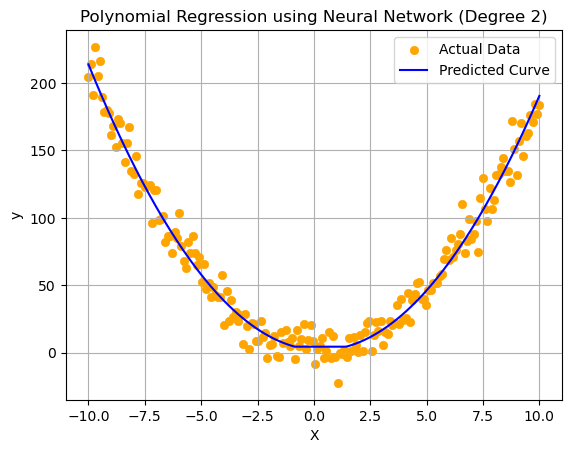

In [10]:
# Sort values for a smooth curve
sorted_indices = X[:, 0].argsort()
X_sorted = X_original[sorted_indices]
y_pred_sorted = y_pred_original[sorted_indices]

plt.scatter(X_original[:, 0], y_original,linewidths= 0.5, label="Actual Data", color='orange')
plt.plot(X_sorted[:, 0], y_pred_sorted, color='b', label="Predicted Curve")
plt.title(f"Polynomial Regression using Neural Network (Degree {degree})")
plt.xlabel("X")
plt.grid()
plt.ylabel("y")
plt.legend()
plt.show()

# 8. Find coefficient of Polynomial

In [11]:
def find_coef(iter):
    total_coef = 0
    for i in range(iter):
        X, Y = 0, 0
        random_index = np.random.choice(len(X_sorted), 3, replace=False)
        X = X_sorted[random_index, 0]
        Y = y_pred_sorted[random_index, 0].reshape(-1, 1)

        ones = np.ones((3, 3))
        ones[:, 0] = X**2
        ones[:, 1] = X

        if np.linalg.det(ones) == 0:
            print("Singular matrix detected. Skipping iteration:", i)
            continue

        coef = np.matmul(np.linalg.pinv(ones), Y)
        total_coef += coef

    coef_abc = total_coef / iter
    print(f'Predict coefficient of Neural Network: a: {coef_abc[0][0]}, b: {coef_abc[1][0]}, c: {coef_abc[2][0]}')
    return coef_abc

In [12]:
predict_coef = find_coef(100)
GenerateQuadraticData().get_init_gen()

Predict coefficient of Neural Network: a: 2.0175241371391768, b: -1.2746062625946712, c: 2.6883945661005466
Actual coefficient of Neural Network: a: 2, b: -2, c: 3
